# Experimenting with ML models
In this notebook, I'm experimenting with a few different models, to see which might be the most favorable option
TODO: Change ALL of this to reflect the fact that I reduced that cardinality of my categorical variables AND filled in model year null values to workaround having to use the imputer, which totally screws the process of trying to use shap and pdp

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [58]:
# Read in data
path = '../data/guitars.csv'
guitars = pd.read_csv(path)

In [59]:
# Remove crazy outliers above $10,000
guitars = guitars.drop(index=guitars.loc[guitars['Price'] > 9999.99].index)

In [60]:
def wrangle(X):
    '''Bulk wrangle for split data'''
    
    # Avoid setting with copy
    X = X.copy()
    
    # Set feature thresholds
    model_limit = 20 # was 50
    brand_limit = 20 # was 50
    color_limit = 20 # was 100
    material_limit = 20 # was 50
    btype_limit = 15 # was 30
    size_limit = 10
    pline_limit = 20 # was 50
    
    # Clean conditions column text
    X['Condition'] = X['Condition'].str.replace('\:\D+', '')
    
    # Make null values out of the incorrectly entered categories
    conditions = ['Used', 'New', 'Open box', 'Seller refurbished',
                  'For parts or not working', 'Manufacturer refurbished']
    
    X.loc[~X['Condition'].isin(conditions), 'Condition'] = np.nan
    
    # Combine columns that are obviously the same and where values are null
    to_merge = {'Right-/ Left-Handed': ['Dexterity', 'Hand'],
                'Country/Region of Manufacture': ['Country of Manufacture'], 
                'Body Color': ['Color'], 'Body Type': ['Type']}
    for main_feat, dup_feat in to_merge.items():
        for f in dup_feat:
            condition = X[main_feat].isnull() & ~X[f].isnull()
            X.loc[condition, main_feat] = X[f]
            # Drop column after merge
        X = X.drop(columns=dup_feat)
    
    # TODO: fix right-left hand business
    # Reduce categories in the right-/ left hand column
    X['Orientation'] = X['Right-/ Left-Handed'].str.upper()
    X['Orientation'] = X['Orientation'].str.replace(
        '(RIGHT OR LEFT|LEFT OR RIGHT|EITHER|LAP|RIGHT-HANDED,).*', 
        'BOTH')
    X['Orientation'] = X['Orientation'].str.replace(
        'R.*', 'RIGHT-HANDED')
    X['Orientation'] = X['Orientation'].str.replace(
        'L.*', 'LEFT-HANDED')
    
    # Remove names that aren't real models from top 100
    X['Model'] = X['Model'].str.upper()
    not_a_model = ['DRN979CTV LH BK 2ND', '39" ELECTRIC GUITAR', '2019',
                   'DOES NOT APPLY', 'UNKNOWN', 'GTR235 LH BK 2ND']  
    top_models = X['Model'].value_counts()[:model_limit].index
    
    X.loc[X['Model'].isin(not_a_model), 'Model'] = 'OTHER'
    X.loc[~X['Model'].isin(top_models), 'Model'] = 'OTHER'
    
    # Clean and shrink the brand column
    X['Brand'] = X['Brand'].str.upper()
    X['Brand'] = X['Brand'].str.replace('UNBRANDED.*', 'UNBRANDED')
    top_brands = X['Brand'].value_counts()[:brand_limit].index
    X.loc[~X['Brand'].isin(top_brands), 'Brand'] = 'OTHER'
    
    # Clean and shrink cardinality of the string configuration column
    standard_configs = ['6 STRING', '7 STRING', '8 STRING', '9 STRING', '12 STRING']
    
    X['String Configuration'] = X['String Configuration'].str.upper()
    X['String Configuration'] = X['String Configuration'].str.replace(
        '6\W*STRING(?!78912).*|^6$|6\s*\w*\s*STRINGS(?!78912)', '6 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('^7$', '7 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('12\W*STRING', '12 STRING')
    
    X.loc[~X['String Configuration'].isin(standard_configs), 'String Configuration'] = 'OTHER'
    
    # Turn UPC and MPN into included and not included categories
    X['UPC'] = X['UPC'].str.upper()
    X.loc[X['UPC'] != 'DOES NOT APPLY', 'UPC'] = 'PROVIDED'
    X.loc[X['UPC'] == 'DOES NOT APPLY', 'UPC'] = 'NOT AVAILABLE'
    
    # If MPN entry contains a digit, it can be considered a valid entry
    mpn_condition = X['MPN'].str.contains('\d')
    X.loc[mpn_condition == True, 'MPN'] = 'PROVIDED'
    X.loc[mpn_condition == False, 'MPN'] = 'NOT AVAILABLE'
    
    # Reduce size, color and material and product line cardinality
    features_limits = {'Body Color': color_limit,
                       'Body Material': material_limit,
                       'Size': size_limit,
                       'Product Line': pline_limit}
    
    for feat, lim in features_limits.items(): # Apply the same wrangling to 3 features
        X[feat] = X[feat].str.upper()
        top = X[feat].value_counts()[:lim].index
        X.loc[~X[feat].isin(top), feat] = 'OTHER'
    
    # Reduce body type cardinality
    X['Body Type'] = X['Body Type'].str.upper()
    top_btypes = X['Body Type'].value_counts().index[:btype_limit]
    X['Body Type'].str.replace('STRAT.*', 'STRATOCASTER')
    X.loc[~X['Body Type'].isin(top_btypes), 'Body Type'] = 'OTHER'
    
    # Make model year a numeric category
    X.loc[X['Model Year'].str.contains('^\d{4}$') == False, 'Model Year'] = np.nan
    X['Model Year'] = X['Model Year'].astype(float)    
    X['Model Year'] = X['Model Year'].fillna(X['Model Year'].mode()[0])
    
    return X

### Beginning With a Baseline
The mean absolute error produced by guessing will help to establish a baseline to begin improving upon. What is the mean absolute error produced by predicting the mean price for every sample

In [24]:
# Start with a baseline
error = guitars['Price'] - guitars['Price'].mean()
mae = error.abs().mean()
print(f'Mean Absolute Error: ${mae:.2f}')

Mean Absolute Error: $505.91


Off by $500 isn't terrible, but for some guitar sales on eBay, that may be completely off the mark, like in the case of guitars sold for ridiculously low prices, i.e. for parts or not working.

### Exploring ML models
Just for comparison's sake, I'm exploring the error produced by a few regression techniques with default parameters. 

In [61]:
# Split into train and test in preparation for cross-validation
train, test = train_test_split(guitars, train_size=0.8, random_state=42)

# Apply wrangling to train and test
train = wrangle(train)
test = wrangle(test)

In [35]:
train.shape, test.shape

((9956, 33), (2489, 33))

In [62]:
train['Model Year'].isna().sum()

0

In [63]:
# Arrange data into X_train and y_train for CV
target = 'Price'
features = ['Model', 'MPN', 'Body Color', 'Brand', 
            'UPC', 'Body Material', 'Body Type', 
            'Model Year', 'Size', 'Country/Region of Manufacture',
            'String Configuration', 'Orientation', 
            'Product Line','Condition']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [87]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 3 folds: [399.66323671 424.92608286 416.1146166 ]
Mean of 3 scores: 413.5679787250571


An error of ~$400 is better than guessing, but not by enough. How does the error look with a random forest regressor?

In [88]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 5 folds: [292.82698315 323.60989948 336.87559167 312.69605078 305.17250817]
Mean of 5 scores: 314.23620665042574


~$300 gets even closer, but it's likely that things can be done to get even closer still, without overfitting the data. The price column is heavily right skewed, so there is some log transformation in order.

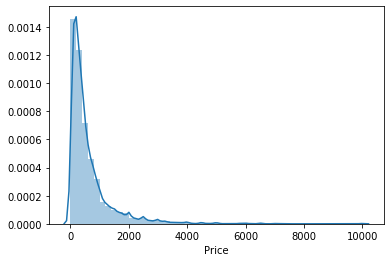

In [10]:
# Visualize skew in price
import seaborn as sns
sns.distplot(y_train);

### Log Transformation
If I log transorm the price, the distribution looks a little more normal

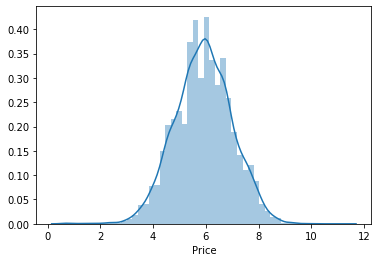

In [92]:
y_log = np.log1p(y_train)
sns.distplot(y_log);

Does the baseline error improve after this transformation?

In [93]:
error = y_log - y_log.mean()
mae_transformed = error.abs().mean()

# Untransform mae
mae = np.expm1(mae_transformed)
print(f'Mean Absolute Error of Log Transformed y: ${mae:.2f}')

Mean Absolute Error of Log Transformed y: $1.36


After transformation, the baseline gets down to less than $2 of error. Does that mean that the models tried before will do much better than before with a log transformed price?

In [94]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 3 folds: [0.4594415  0.47395378 0.46821541]
Mean of 3 scores: 0.4672035637421595


Now the linear regression model's error is down below $1

In [95]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 5 folds: [0.38653353 0.38874631 0.37980542 0.39411032 0.38616535]
Mean of 5 scores: 0.3870721859074081


With a random forest regressor, the error lies below 40 cents

### XGBoost and Permutation Importance

In [8]:
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance

/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [64]:
# Split again into train and validation set for permutation importances
train, val = train_test_split(train, train_size=0.8, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

train.shape, val.shape

((7964, 33), (1992, 33))

In [65]:
X_train['Model Year'].isna().sum()

0

In the random forest model, what were the most important features? To answer this question, I'll use a permutation importance visualization to display the weight of each feature

In [70]:
# Use pipeline for transformers only
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
)

# Log Transform y_train and y_val
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Fit the model to the transformed X_train and y_log
model.fit(X_train_transformed, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [71]:
%%time
# Calculate permutation importance
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val_log)

CPU times: user 3min 48s, sys: 21 s, total: 4min 9s
Wall time: 2min 35s


PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [72]:
# Display permutation importances
feature_names = X_val_transformed.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names# Show all
)

Weight,Feature
0.1429 ± 0.0100,Country/Region of Manufacture_United States
0.1004 ± 0.0093,Model Year
0.0446 ± 0.0030,Brand_GIBSON
0.0373 ± 0.0081,Size_OTHER
0.0353 ± 0.0045,Brand_UNBRANDED
0.0282 ± 0.0041,Body Color_OTHER
0.0258 ± 0.0075,Product Line_OTHER
0.0220 ± 0.0024,Brand_OTHER
0.0210 ± 0.0090,Condition_New
0.0163 ± 0.0040,MPN_PROVIDED


It Looks like all the features I had previously chosen have an considerable effect on price, namely Brand and Country/Region of Manufacture

In [73]:
# Fit XGBoost, stop early
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train, y_train_log)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    n_estimators=1000,
    random_state=42, 
    n_jobs=-1, 
    max_depth=16,
    learning_rate=0.5,
    )

eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model.fit(X_train_encoded, y_train_log,
          eval_set=eval_set,
          eval_metric='mae',
          early_stopping_rounds=100)

[08:42:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.71966	validation_1-mae:2.70873
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:1.41376	validation_1-mae:1.40398
[2]	validation_0-mae:0.839702	validation_1-mae:0.852402
[3]	validation_0-mae:0.577532	validation_1-mae:0.649097
[4]	validation_0-mae:0.467881	validation_1-mae:0.577883
[5]	validation_0-mae:0.434227	validation_1-mae:0.555156
[6]	validation_0-mae:0.419938	validation_1-mae:0.550917
[7]	validation_0-mae:0.402813	validation_1-mae:0.546884
[8]	validation_0-mae:0.384648	validation_1-mae:0.542541
[9]	validation_0-mae:0.375643	validation_1-mae:0.540314
[10]	validation_0-mae:0.372408	validation_1-mae:0.539777
[11]	validation_0-mae:0.359536	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

The xgboost did not perform as well on the validation set as the cross validated, but this does not necessarily mean that it will perform poorly on the test set; the error is still below $1

In [74]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = model.predict(X_val_encoded)
mae = mean_absolute_error(y_val_log, y_pred)
mae_untransformed = np.expm1(mae)
mae_untransformed

0.6785116116150776

What is the R^2 score?

In [75]:
r2_score(y_val_log, y_pred)

0.5076351255009981

### Partial Dependence Plots
How does Body Color affect the prediction? I had originally hypothesized that color would have an important effect on a buyer's perspective of the guitar's worth.

In [77]:
from pdpbox.pdp import pdp_isolate, pdp_plot
# TODO: Try using a model with one hot encoder to represent pdp for categorical variables
feature = 'Brand_GIBSON'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

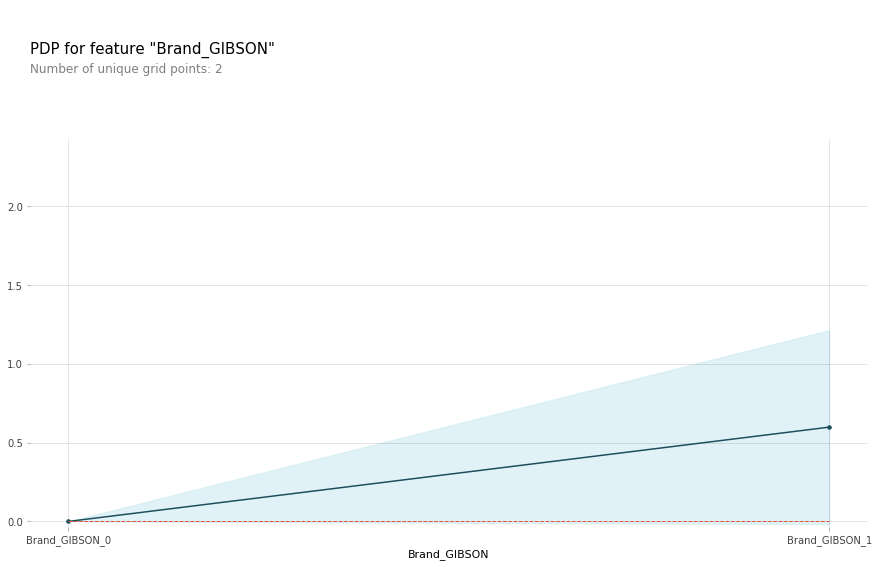

In [78]:
pdp_plot(isolated, feature_name=feature);

In [20]:
X_train['Model Year'].isnull().sum()
# initial strategy to deal with nans as it relates to getting shapley value plot
# and partial dependence plot: find out what the imputer does to the rows and
# find out if this weeks lecture notebooks that
# a) use permutation importance | shap | pdpbox use any sort of encoding/imputing
# b) if so, how do they handle the encoded columns, or imputed values

4952

In [79]:
import shap

In [80]:
row = X_val_transformed.iloc[[0]]
row

,Model_OTHER,Model_CLASSIC,Model_CUSTOM,Model_VINTAGE,Model_LES PAUL STANDARD,Model_LES PAUL TRADITIONAL,Model_LES PAUL,Model_PLUS,Model_LES PAUL STUDIO,Model_FLYING V,...,Product Line_EPIPHONE LES PAUL STANDARD PLUSTOP PRO,Product Line_GIBSON EXPLORER,Product Line_EPIPHONE LES PAUL CUSTOM PRO,Condition_New,Condition_Used,Condition_nan,Condition_Open box,Condition_Seller refurbished,Condition_For parts or not working,Condition_Manufacturer refurbished
6270,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [81]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap_values

array([[ 6.51249065e-05,  2.57830787e-03, -3.18329153e-03,
         2.69642426e-03,  2.02755808e-04,  4.31234039e-05,
         9.29198985e-04, -2.58075277e-04,  1.50413648e-03,
        -1.00705372e-04, -6.87843934e-03,  1.42460791e-04,
         1.69110636e-03, -2.07887788e-05,  2.54568178e-04,
         2.55767582e-03,  8.15349165e-04,  3.55572847e-04,
         5.23574681e-06,  1.58273114e-03,  9.08234942e-05,
        -2.86352709e-02, -2.52484139e-02,  1.05081396e-02,
         1.67201844e-03, -1.47811202e-02, -5.53066004e-03,
        -1.06396631e-03,  1.96212437e-04,  2.28097383e-02,
         5.71251032e-04,  1.55452872e-02,  1.97413436e-04,
        -1.63855776e-03,  3.54383985e-04,  3.28041520e-03,
         6.95377879e-04,  1.28478615e-03,  1.63705926e-03,
        -3.34832526e-04, -3.63010258e-05,  6.10442553e-03,
        -7.11723405e-04, -3.24855646e-04,  3.22759093e-04,
         1.49170440e-02,  4.33511734e-02,  1.17494538e-02,
        -5.12052298e-01, -9.24657652e-05, -2.66537303e-0

In [83]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)